In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import random
from deap import base, creator, tools
import matplotlib.pyplot as plt


In [ ]:
# Define Fuzzy Variables
distance = ctrl.Antecedent(np.arange(0, 101, 1), 'distance')
speed = ctrl.Antecedent(np.arange(0, 101, 1), 'speed')
braking = ctrl.Consequent(np.arange(0, 101, 1), 'braking')

# Define Membership Functions for Distance
distance['close'] = fuzz.trimf(distance.universe, [0, 0, 50])
distance['medium'] = fuzz.trimf(distance.universe, [0, 50, 100])
distance['far'] = fuzz.trimf(distance.universe, [50, 100, 100])

# Define Membership Functions for Speed
speed['slow'] = fuzz.trimf(speed.universe, [0, 0, 50])
speed['average'] = fuzz.trimf(speed.universe, [0, 50, 100])
speed['fast'] = fuzz.trimf(speed.universe, [50, 100, 100])

# Define Membership Functions for Braking
braking['low'] = fuzz.trimf(braking.universe, [0, 0, 50])
braking['moderate'] = fuzz.trimf(braking.universe, [0, 50, 100])
braking['high'] = fuzz.trimf(braking.universe, [50, 100, 100])

# Define Fuzzy Rules
rule1 = ctrl.Rule(distance['close'] & speed['fast'], braking['high'])
rule2 = ctrl.Rule(distance['close'] & speed['slow'], braking['moderate'])
rule3 = ctrl.Rule(distance['medium'] & speed['fast'], braking['moderate'])
rule4 = ctrl.Rule(distance['far'] & speed['slow'], braking['low'])
rule5 = ctrl.Rule(distance['medium'] & speed['average'], braking['moderate'])  # Added for balance

# Control System Creation
braking_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
braking_sim = ctrl.ControlSystemSimulation(braking_ctrl)


In [ ]:
def debug_fuzzification(distance_val, speed_val):
    # Distance membership degrees
    close_membership = fuzz.interp_membership(distance.universe, distance['close'].mf, distance_val)
    medium_membership = fuzz.interp_membership(distance.universe, distance['medium'].mf, distance_val)
    far_membership = fuzz.interp_membership(distance.universe, distance['far'].mf, distance_val)

    # Speed membership degrees
    slow_membership = fuzz.interp_membership(speed.universe, speed['slow'].mf, speed_val)
    average_membership = fuzz.interp_membership(speed.universe, speed['average'].mf, speed_val)
    fast_membership = fuzz.interp_membership(speed.universe, speed['fast'].mf, speed_val)

    # Print the membership values for distance
    print(f"Fuzzification of Distance {distance_val}:")
    print(f"Close: {close_membership}")
    print(f"Medium: {medium_membership}")
    print(f"Far: {far_membership}")

    # Print the membership values for speed
    print(f"\nFuzzification of Speed {speed_val}:")
    print(f"Slow: {slow_membership}")
    print(f"Average: {average_membership}")
    print(f"Fast: {fast_membership}")

# Call the debug function for fuzzification
debug_fuzzification(50, 50)


Fuzzification of Distance 50:
Close: 0.0
Medium: 1.0
Far: 0.0

Fuzzification of Speed 50:
Slow: 0.0
Average: 1.0
Fast: 0.0


In [ ]:
def compute_braking_force(distance_val, speed_val):
    # Reinitialize the control system simulation to reset state
    braking_sim = ctrl.ControlSystemSimulation(braking_ctrl)

    # Assign inputs
    braking_sim.input['distance'] = distance_val
    braking_sim.input['speed'] = speed_val

    try:
        # Perform the fuzzy computation
        braking_sim.compute()

        # Return the computed 'braking' output if it exists, otherwise return a default value
        if 'braking' in braking_sim.output:
            return braking_sim.output['braking']
        else:
            print(f"Error: 'braking' output not found for distance={distance_val}, speed={speed_val}. Returning default value.")
            return 0  # Default value to prevent crashes
    except Exception as e:
        print(f"Exception during fuzzy computation: {e}")
        return 0  # Default value for exceptions


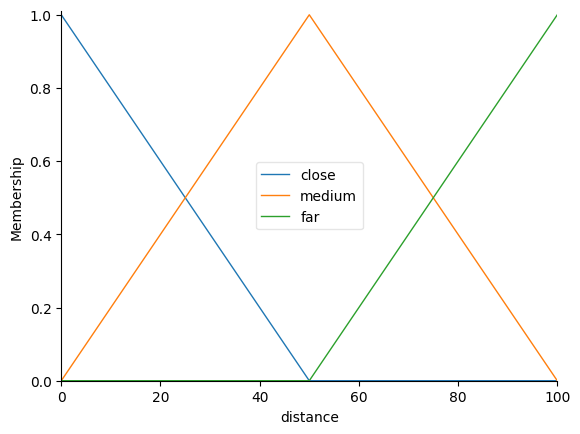

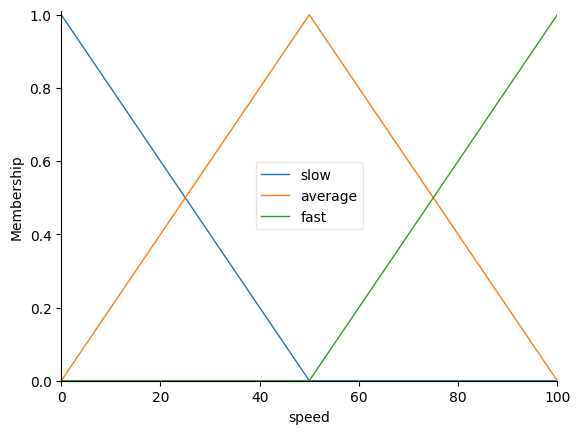

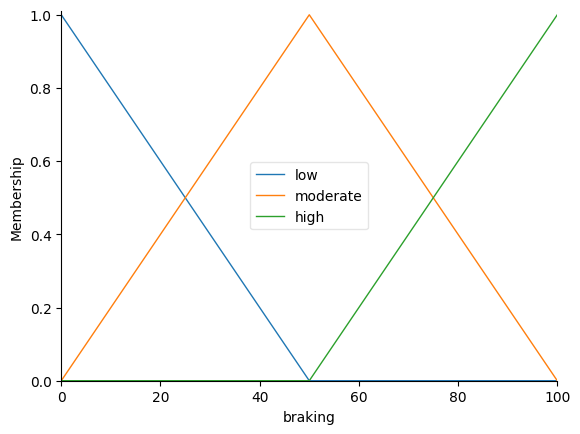

In [ ]:
# Visualize the membership functions for debugging purposes
distance.view()
speed.view()
braking.view()
plt.show()


In [ ]:
from deap import base, creator, tools
import random

# Safeguard for class creation to avoid the warning when running multiple times
if not hasattr(creator, "FitnessMin"):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMin)

# Define individual structure (each individual represents 5 rule weights)
def create_individual():
    return [random.uniform(-1, 1) for _ in range(5)]  # 5 rule weights for the 5 rules

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function: minimize the error in braking predictions
def evaluate(individual):
    # Modify rule strengths based on the individual (rule weights optimization)
    weights = individual
    rule1.weight = weights[0]
    rule2.weight = weights[1]
    rule3.weight = weights[2]
    rule4.weight = weights[3]
    rule5.weight = weights[4]

    # Example test data (distance, speed) with desired braking force
    test_data = [(20, 80, 90), (50, 50, 50), (80, 30, 20), (30, 100, 80)]  # (distance, speed, expected_braking)

    error = 0.0
    for distance_val, speed_val, expected in test_data:
        predicted = compute_braking_force(distance_val, speed_val)
        # Safeguard in case 'predicted' is None or an invalid type
        if predicted is not None:
            error += abs(predicted - expected)  # Minimize the error
        else:
            error += 100  # Assign high penalty for invalid results to force evolution away from bad individuals

    return (error,)

# Register genetic operators
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Blend crossover
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
def main():
    # Create population
    pop = toolbox.population(n=50)

    # Define GA parameters
    n_gen = 20  # Number of generations
    cx_prob = 0.5  # Crossover probability
    mut_prob = 0.2  # Mutation probability

    # Use DEAP's algorithms for evolution
    for gen in range(n_gen):
        # Select and clone the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cx_prob:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mut_prob:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate fitness for new individuals
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Replace the population with the new offspring
        pop[:] = offspring

        # Output the best individual of the generation
        fits = [ind.fitness.values[0] for ind in pop]
        best_ind = tools.selBest(pop, 1)[0]
        print(f"Gen {gen}: Best fitness = {min(fits)} | Best individual = {best_ind}")

    return pop

# Run the genetic algorithm
final_population = main()


Gen 0: Best fitness = 82.63658143827826 | Best individual = [-1.6318907283461423, 0.6001879764409859, -0.7776800228002332, -0.7950604473351437, 0.6468767177390315]
Gen 1: Best fitness = 82.63658143827826 | Best individual = [-0.10518697487327922, 0.5590204885333654, -0.4659515790059914, -0.0190623062893005, -0.5644652652618061]
Gen 2: Best fitness = 82.63658143827826 | Best individual = [0.8219751023799089, -0.20090466307048738, 0.31223951227868185, -0.8451618881552139, -0.37464582812560476]
Gen 3: Best fitness = 82.63658143827826 | Best individual = [-0.3221982534898859, 1.5368674173676218, -1.0810578523574172, -0.1467411548189609, 1.2545527631025966]
Gen 4: Best fitness = 82.63658143827826 | Best individual = [0.21324543297247306, 0.04851421093525636, 0.29382759449279766, -0.36549877164873795, -0.05720532414188094]
Gen 5: Best fitness = 82.63658143827826 | Best individual = [-2.057995320928368, 0.49725830961752515, 0.4917846823943408, -0.8206102778019628, 0.10060057930256414]
Gen 6: 